In [4]:
# https://github.com/jscancella/NYTribuneOCRExperiments/blob/master/findText_usingSums.py
import os
import io
from pathlib import Path
import sys
os.environ['OPENCV_IO_ENABLE_JASPER']='True' # has to be set before importing cv2 otherwise it won't read the variable
import cv2
import numpy as np
import subprocess
from multiprocessing import Pool
from scipy.signal import find_peaks
from IPython.display import Image as KImage
!conda info


     active environment : base
    active env location : /home/alex/miniconda3
            shell level : 1
       user config file : /home/alex/.condarc
 populated config files : 
          conda version : 4.9.2
    conda-build version : not installed
         python version : 3.8.3.final.0
       virtual packages : __glibc=2.32=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /home/alex/miniconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /home/alex/miniconda3/pkgs
                          /home/alex/.conda/pkgs
       envs directories : /home/alex/miniconda3/envs
                          /home/alex/.conda/envs
               platform : linux-64
          

# Adaptative Thresholding - to make document B/W

In [5]:
# Run adaptative thresholding (is slow af compared to not using it in pipeline)
def adaptative_thresholding(img, threshold):
    # Load image
    I = img
    # Convert image to grayscale
    gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    # Original image size
    orignrows, origncols = gray.shape
    # Windows size
    M = int(np.floor(orignrows/16) + 1)
    N = int(np.floor(origncols/16) + 1)
    # Image border padding related to windows size
    Mextend = round(M/2)-1
    Nextend = round(N/2)-1
    # Padding image
    aux =cv2.copyMakeBorder(gray, top=Mextend, bottom=Mextend, left=Nextend,
                          right=Nextend, borderType=cv2.BORDER_REFLECT)
    windows = np.zeros((M,N),np.int32)
    # Image integral calculation
    imageIntegral = cv2.integral(aux, windows,-1)
    # Integral image size
    nrows, ncols = imageIntegral.shape
    # Memory allocation for cumulative region image
    result = np.zeros((orignrows, origncols))
    # Image cumulative pixels in windows size calculation
    for i in range(nrows-M):
        for j in range(ncols-N):
            result[i, j] = imageIntegral[i+M, j+N] - imageIntegral[i, j+N]+ imageIntegral[i, j] - imageIntegral[i+M,j]

    # Output binary image memory allocation
    binar = np.ones((orignrows, origncols), dtype=np.bool)
    # Gray image weighted by windows size
    graymult = (gray).astype('float64')*M*N
    # Output image binarization
    binar[graymult <= result*(100.0 - threshold)/100.0] = False
    # binary image to UINT8 conversion
    binar = (255*binar).astype(np.uint8)

    return binar


In [6]:
# static variables for clarity
COLUMNS = 0
GREEN = (0, 255, 0)

# parameters that can be tweaked
LINE_THICKNESS = 3 # how thick to make the line around the found contours in the debug output
PADDING = 10 # padding to add around the found possible column to help account for image skew and such
CREATE_COLUMN_OUTLINE_IMAGES = True # if we detect that we didn't find all the columns. Create a debug image (tiff) showing the columns that were found

def columnIndexes(a):
    """
    creates pair of indexes for left and right index of the image column
    For example [13, 1257, 2474, 3695, 4907, 6149]
    becomes: [[13 1257], [1257 2474], [2474 3695], [3695 4907], [4907 6149]]
    """
    nrows = (a.size-2)+1
    return a[1*np.arange(nrows)[:,None] + np.arange(2)]

def convertToGrayscale(img):
    temp_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return temp_img

def invert(img):
    """ Black -> White | White -> Black """
    print("invert image")
    # Should we edit these parameters?
    _,temp_img = cv2.threshold(img, 140, 255, cv2.THRESH_BINARY_INV)
    return temp_img

# Create a set of column images from a base image and output directory

In [7]:
def createColumnImages(img, basename, directory):
    """
    we sum each column of the inverted image. The columns should show up as peaks in the sums
    uses scipy.signal.find_peaks to find those peaks and use them as column indexes
    """
    files = []
    temp_img = convertToGrayscale(img)
    temp_img = invert(temp_img)

    sums = np.sum(temp_img, axis = COLUMNS)
    sums[0] = 1000 # some random value so that find_peaks properly detects the peak for the left most column
    sums = sums * -4 # invert so that minimums become maximums and exagerate the data so it is more clear what the peaks are
    peaks, _ = find_peaks(sums, distance=800) # the column indexs of the img array, spaced at least 800 away from the previous peak

    if peaks.size == 0:
        with open('troublesomeImages.txt', 'a') as f:
            print("ERROR: something went wrong with finding the peaks for image: ", os.path.join(directory, basename))
            f.write(os.path.join(directory, basename) + ".jpg 0\n")
        return files

    peaks[0] = 0 # automatically make the left most column index the start of the image
    peaks[-1] =sums.size -1 # automatically make the right most column index the end of the image

    boxed = np.copy(img)
    if peaks.size < 6:
        with open('troublesomeImages.txt', 'a') as f:
            print("found image that is causing problems: ", os.path.join(directory, basename))
            f.write(os.path.join(directory, basename) + ".jpg " + str(peaks.size) + "\n")

    columnIndexPairs = columnIndexes(peaks)

    ystart = 0
    yend = img.shape[0]
    for columnIndexPair in columnIndexPairs:
        xstart = max(columnIndexPair[0]-PADDING, 0)
        xend = min(columnIndexPair[1]+PADDING, img.shape[1])
        filepath = os.path.join(directory, '%s_xStart%s_xEnd%s.jpg' % (basename, xstart,xend))
        files.append(filepath)
        crop_img = img[ystart:yend, xstart:xend]
        if not os.path.exists(filepath):
            print("writing out cropped image: ", filepath)
            # Apply adaptative thresholding to the image with a threshold of 25/100
            #crop_img = adaptative_thresholding(crop_img, 25)
            cv2.imwrite(filepath, crop_img)

        if CREATE_COLUMN_OUTLINE_IMAGES:
            cv2.rectangle(boxed,(xstart,ystart),(xend,yend), GREEN, LINE_THICKNESS)

    if CREATE_COLUMN_OUTLINE_IMAGES:
        filepath = os.path.join(directory, '%s-contours.jpeg' % basename)
        cv2.imwrite(filepath, boxed, [cv2.IMWRITE_JPEG_QUALITY, 50])
        # For removing the old image?
        # os.remove(os.path.join(directory, basename + ".jp2"))

    return files


In [8]:
# replace tester with the commonwealthId_pagenum in the future...
# The first parameter should be each folder in the downloaded data in the future...
createColumnImages(cv2.imread('./data/test.jpg'), 'tester', './')

invert image


['./tester_xStart0_xEnd1184.jpg',
 './tester_xStart1164_xEnd2042.jpg',
 './tester_xStart2022_xEnd2878.jpg',
 './tester_xStart2858_xEnd3741.jpg',
 './tester_xStart3721_xEnd4618.jpg',
 './tester_xStart4598_xEnd5727.jpg']

# Inspect the column detection results

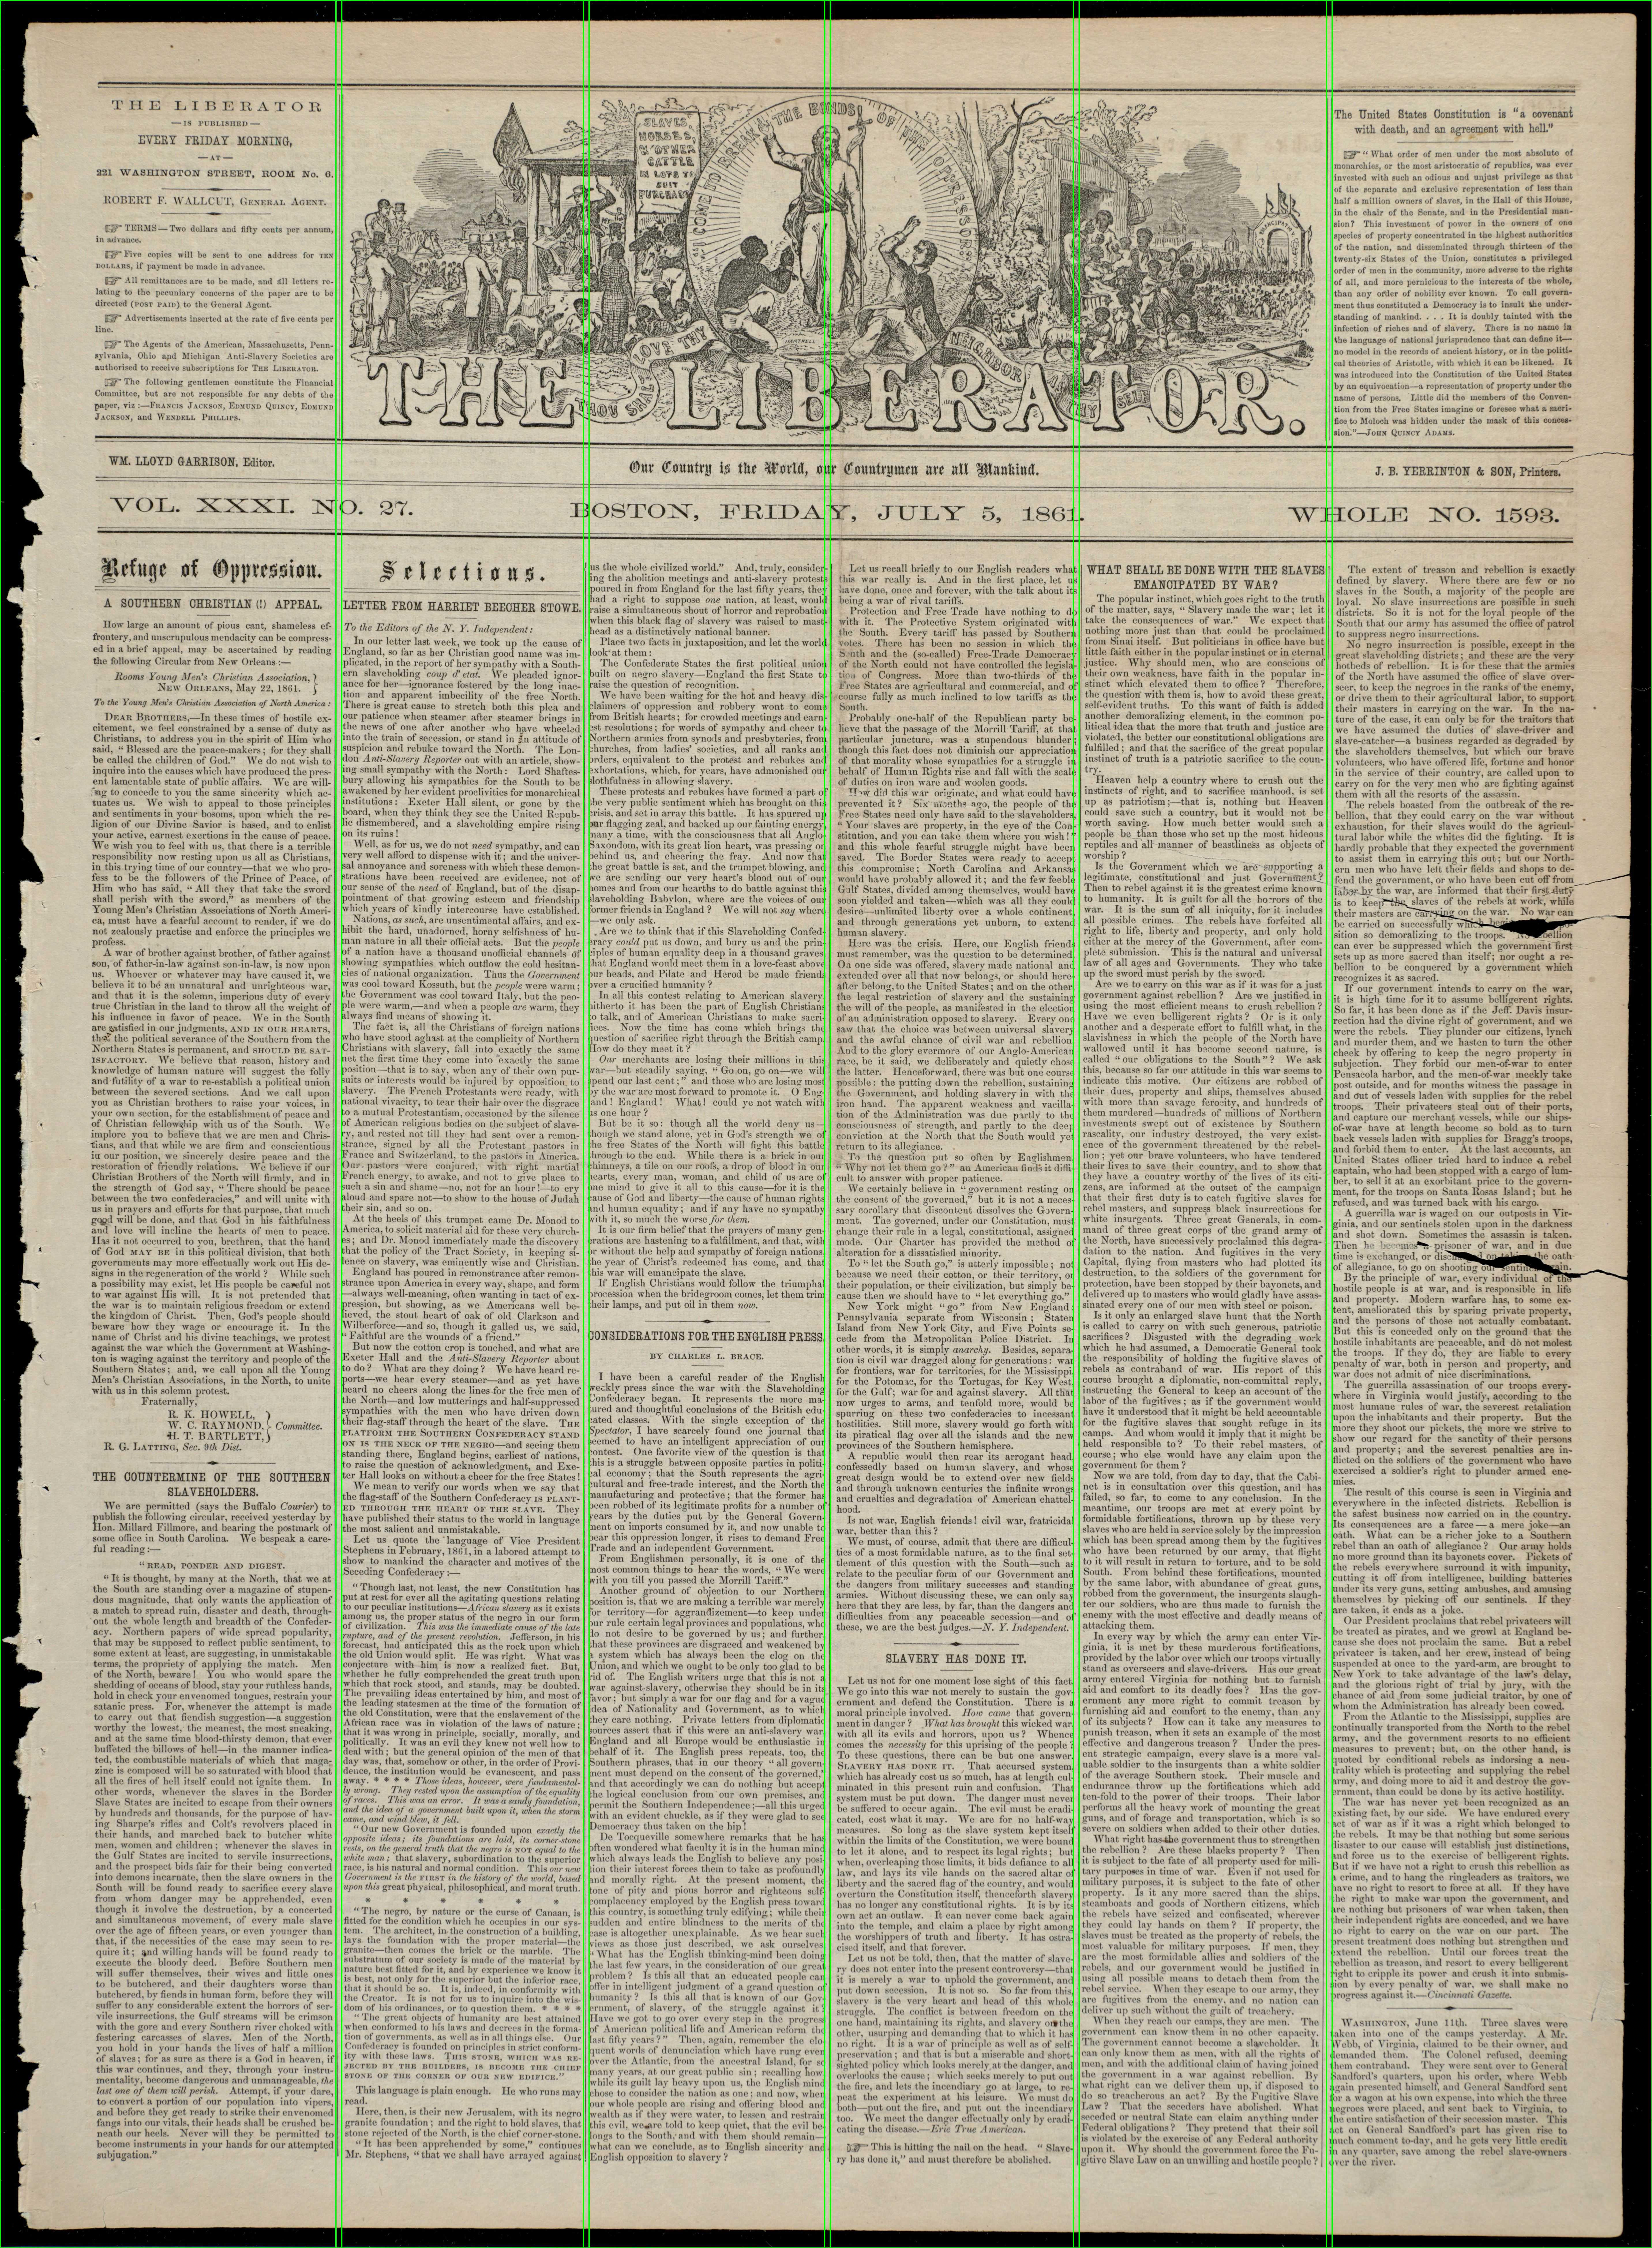

In [9]:
KImage(filename='tester-contours.jpeg') 

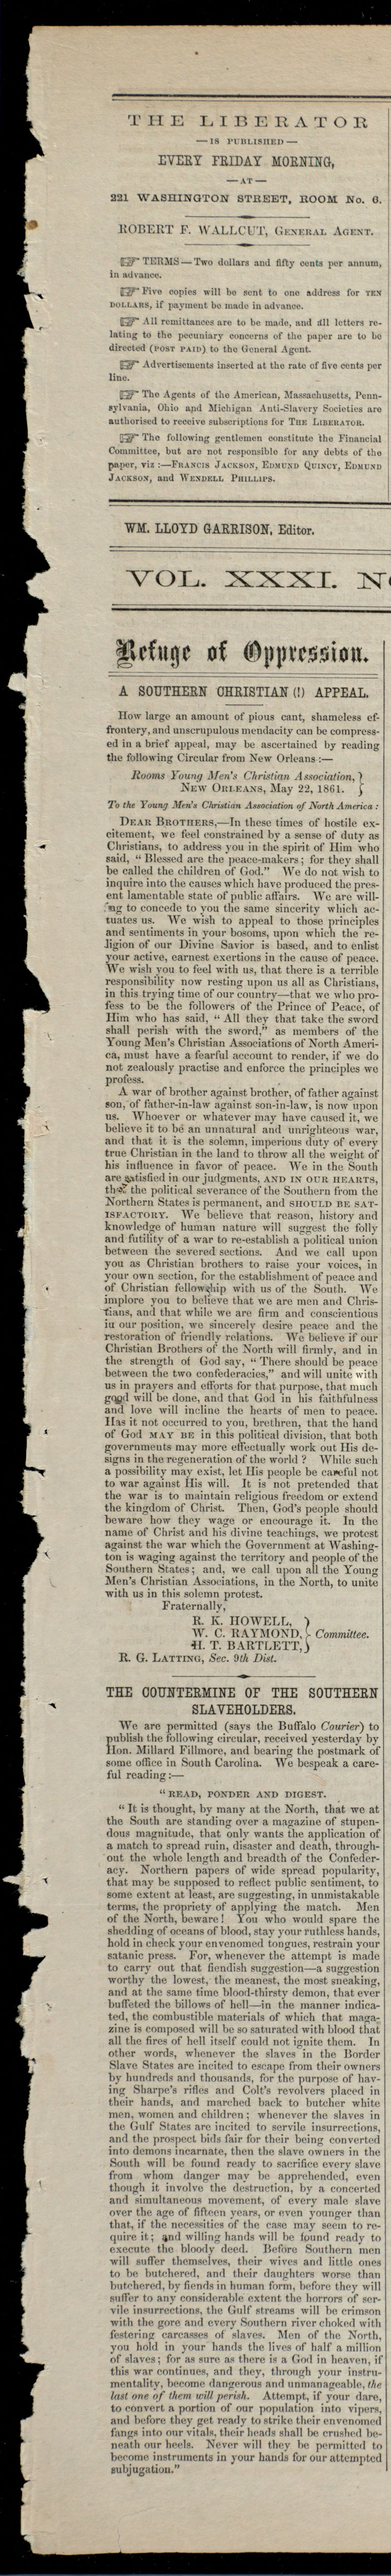

In [10]:
KImage(filename='./tester_xStart0_xEnd1184.jpg') 

# Integrate with Google Cloud Vision API

In [11]:
# This environment variable needs to be set with your credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/alex/Downloads/credentials.json"
print(os.environ['GOOGLE_APPLICATION_CREDENTIALS']) 

~/Downloads/credentials.json


In [12]:
# Imports the Google Cloud client library
from google.cloud import vision_v1 as vision

# Instantiates a client
client = vision.ImageAnnotatorClient()

# Read in one of the column images to test out Google Cloud Vision DOCUMENT_TEXT_DETECTION
# https://cloud.google.com/vision/docs/ocr
file_name = os.path.abspath('./tester_xStart0_xEnd1184.jpg')

# Loads the image into memory
with io.open(file_name, 'rb') as image_file:
    image = image_file.read()

# Hit the API and get back the text annotations (description is the good part)
response = client.text_detection(image=image)
if response.error.message:
    raise Exception('{}'.format(response.error.message))
    
texts = response.text_annotations

# Print the results 
for text in texts:
    print('\n\n\n"{}"'.format(text.description))
    pass

DefaultCredentialsError: File ~/Downloads/credentials.json was not found.

# Look at the first extracted text segment

In [ ]:
dirty = texts[0].description.strip()
print(dirty)

# Try to auto-correct / clean-up the OCR text (needs tuning)

In [ ]:
# https://github.com/fsondej/autocorrect
from autocorrect import Speller
spell = Speller(only_replacements=True)
fixed = spell(dirty)
print(fixed)

# Compare the two and view the changes

In [ ]:
import difflib

d = difflib.Differ()
diff = d.compare(dirty.splitlines(), fixed.splitlines())

print('\n'.join(diff))

# Run OOTB NER on the text (will likely need to be tuned)

In [ ]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(fixed)
displacy.serve(doc, style="ent")

# To Do: 
### Object detection of start/stop markers
### article extraction
### stitching text together and correcting the text, 
### crop images before passing to Cloud Vision, use higher quality files (TIFF) for better text detection